Data source:
Kaggle. (2012). Titanic: Machine Learning from Disaster. Retrieved from https://www.kaggle.com/c/titanic/data.

In this tutorial, we will walk through the process of getting a decision tree-based explanation for model predictions on the Titanic dataset. We will see which features contribute most to survival predictions for passengers who were on board the Titanic. The data loading and pre-processing steps are identical to tutorials of the global and local feature contributions.


In [2]:
import pandas as pd
import numpy as np

np.random.seed(123)

We will begin by loading the data, and writing out human-readable descriptions of all features.

In [3]:
from sklearn.model_selection import train_test_split
from pyreal.applications import titanic

np.random.seed(1)

x_orig, y = titanic.load_titanic_data()

x_train_orig, x_test_orig, y_train, y_test = train_test_split(x_orig, y, test_size=.20)

print("Features:", x_orig.columns.values)

feature_descriptions = {
    "PassengerId": "Passenger ID",
    "Pclass": "Ticket Class",
    "SibSp": "Number of siblings/spouses aboard",
    "Parch": "Number of parents/children aboard",
    "Ticket": "Ticket Number",
    "Fare": "Passenger Fare",
    "Cabin": "Cabin Number",
    "Embarked": "Port of Embarkment",
}

Features: ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [4]:
from pyreal.utils.transformer import OneHotEncoderWrapper, ColumnDropTransformer, MultiTypeImputer
from pyreal.utils.transformer import fit_transformers, run_transformers

column_drop = ColumnDropTransformer(["PassengerId", "Name", "Ticket", "Cabin"])
imputer = MultiTypeImputer()
one_hot_encoder = OneHotEncoderWrapper(["Sex", "Embarked"])

transformers = [column_drop, imputer, one_hot_encoder]
fit_transformers(transformers, x_train_orig)
x_transform_train = run_transformers(transformers, x_train_orig)
x_transform_test = run_transformers(transformers, x_test_orig)

Next, we will make the transformers. `Pyreal`'s built-in transformers all have explanation transforms, which bring explanations from the model form to the interpretable form.

In [5]:
from sklearn.linear_model import LogisticRegression
import pickle

model = LogisticRegression(max_iter=500)
model.fit(x_transform_train, y_train)

preds = model.predict(x_transform_test)
print("Test accuracy: %.2f" % (np.mean(preds==y_test)*100))

Test accuracy: 79.89


Now, we can make the decision tree explainer...

In [30]:
from pyreal.explainers import DecisionTreeExplainer

dte = DecisionTreeExplainer(model=model, x_train_orig=x_train_orig, is_classifier=True, max_depth=5,
                            m_transforms=transformers, e_transforms=transformers,  
                            feature_descriptions=feature_descriptions, fit_on_init=True)

... and visualize the explanation by plotting the explanation tree.

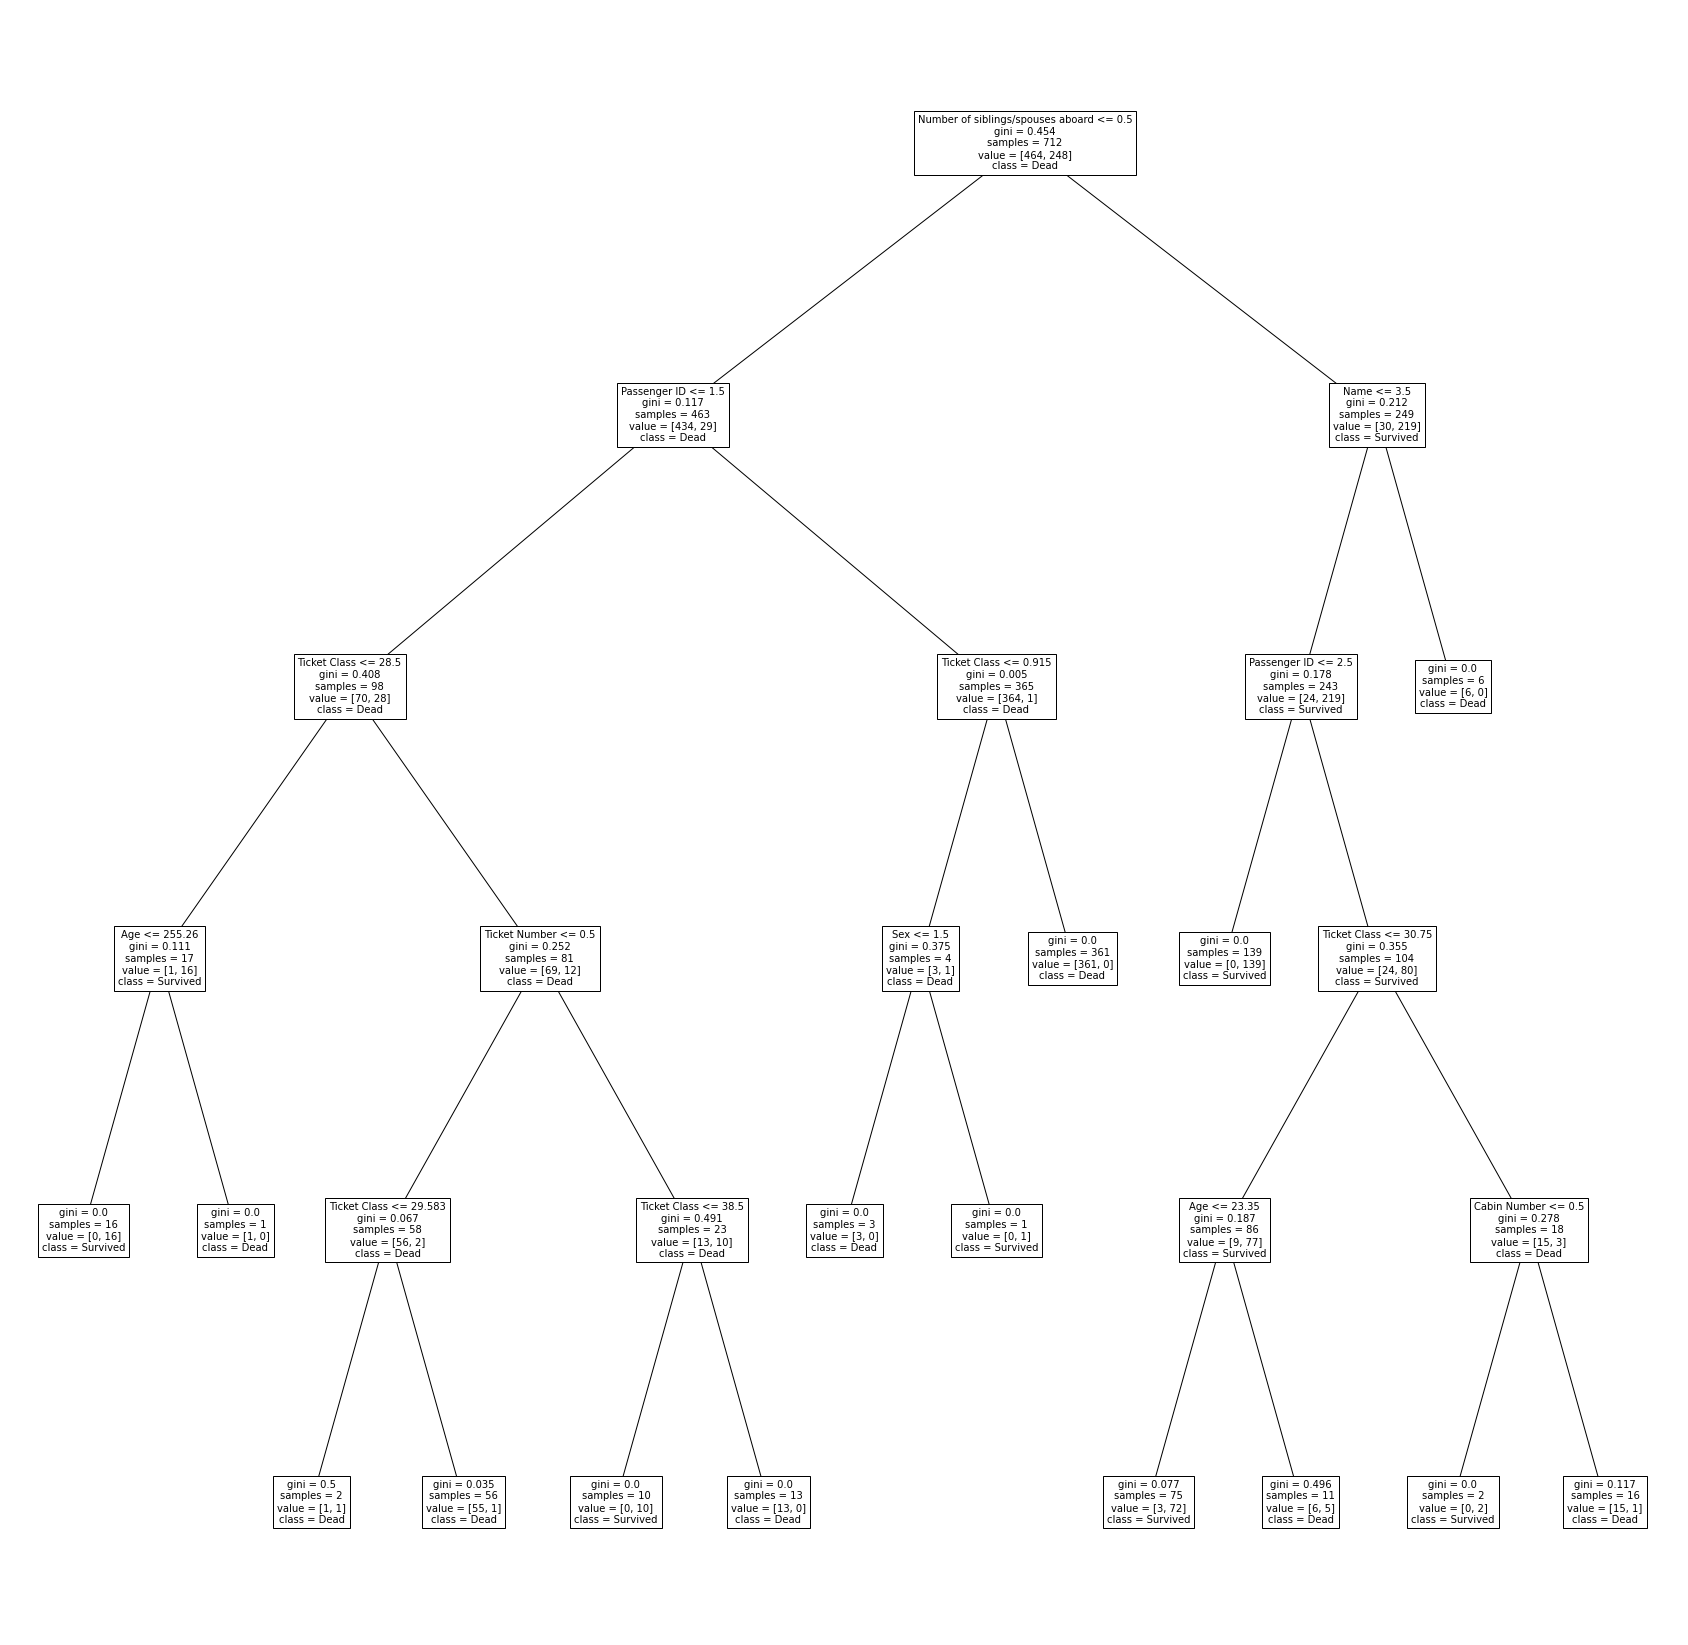

In [33]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

features = []
for feature in x_orig.columns:
    if feature in feature_descriptions.keys():
        features.append(feature_descriptions[feature])
    else:
        features.append(feature)

decision_tree = dte.produce()

fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(decision_tree, feature_names=features, class_names=["Dead", "Survived"], fontsize=10, ax=ax)
plt.show()

... and again, visualize the explanation.

To visualize the model and features in the form of decision tree explainer...